In [10]:
# python libraries
import numpy as np
from IPython.display import HTML, display
# pydrake imports
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, DirectCollocation, Solve,
                         Linearize, LinearQuadraticRegulator, LogVectorOutput,
                         MeshcatVisualizer, ModelVisualizer, Parser, Simulator, StartMeshcat)

from underactuated import running_as_notebook

from pydrake.all import (
    Box,
    CoulombFriction,
    Cylinder,
    PrismaticJoint,
    RevoluteJoint,
    RigidTransform,
    SpatialInertia,
    Sphere,
    UnitInertia,
    RotationMatrix,
    JointSliders,
    RollPitchYaw,
    FixedOffsetFrame,
    JointActuator,
    PiecewisePolynomial
)
from pydrake.all import MultibodyPlant, SceneGraph
from underactuated.scenarios import AddShape
import math
from matplotlib import pyplot as plt

In [3]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://cf831d60-e146-4439-9c7b-f762dc47b76b.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


## Trajectory Optimization of a Free-Falling Cat

In [4]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

In [38]:
seg_length = 0.175   # m
seg_diam = 0.15      # m
seg_mass = 1         # kg
segXverse_moi = 1    # kg-m^2
JIratio = 0.25       # (xverse to axial MOI ratio)
# tau_max = 40Nm (max torque)
I_xx = JIratio*segXverse_moi      # segAxialMOI
I_yy = segXverse_moi
I_zz = segXverse_moi
# I_yy = I_zz = segXverseMOI
# I_xy = I_xz = I_yz = 0

# S
# B1
# B2


# Uncomment the below 2 lines for joint sliders
builder = DiagramBuilder()
cat_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

# Direct Collocation maybe
# cat_plant = MultibodyPlant(0.0)
# scene_graph = SceneGraph()
# cat_plant.RegisterAsSourceForSceneGraph(scene_graph)

segment1_inertia = SpatialInertia(
                mass=1, p_PScm_E=[0.0,0.0,0.0], G_SP_E=UnitInertia(I_xx, I_yy, I_zz))
segment2_inertia = SpatialInertia(
                mass=1, p_PScm_E=[0.0,0.0,0.0], G_SP_E=UnitInertia(I_xx, I_yy, I_zz))
no_inertia = SpatialInertia(
        mass=0, p_PScm_E=[0.0, 0.0, 0.0], G_SP_E=UnitInertia(0, 0, 0))
segment1_shape = Cylinder(seg_diam/2, seg_length)
segment2_shape = Cylinder(seg_diam/2, seg_length)

s_body = cat_plant.AddRigidBody("S", no_inertia)
B1_ry_body = cat_plant.AddRigidBody("B1_ry_body", no_inertia)
B2_ry_body = cat_plant.AddRigidBody("B2_ry_body", no_inertia)
B1_body = cat_plant.AddRigidBody("B1", segment1_inertia)
B2_body = cat_plant.AddRigidBody("B2", segment2_inertia)

B1_end_frame = cat_plant.AddFrame(FixedOffsetFrame("B1_end", B1_body.body_frame(), xyz_rpy_deg([-seg_length/2,0,0],[0,0,0])))
B2_end_frame = cat_plant.AddFrame(FixedOffsetFrame("B2_end", B2_body.body_frame(), xyz_rpy_deg([seg_length/2,0,0],[0,0,0])))

cyl1_xform = xyz_rpy_deg([0,0,0], [90,0,90])
cyl2_xform = xyz_rpy_deg([0,0,0], [90,0,-90])
leg1_xform = xyz_rpy_deg([0.0525, 0.05, 0.0866], [-30,0,0])
leg2_xform = xyz_rpy_deg([0.0525, -0.05, 0.0866], [30,0,0])
leg3_xform = xyz_rpy_deg([-0.0525, 0.05, 0.0866], [-30,0,0])
leg4_xform = xyz_rpy_deg([-0.0525, -0.05, 0.0866], [30,0,0])
leg_shape = Box(.02, .02, .1)
cube_shape = Box(.02, .02, .02)
no_xform = xyz_rpy_deg([0,0,0],[0,0,0])
B1_geoID = cat_plant.RegisterVisualGeometry(B1_body, cyl1_xform, segment1_shape, "B1_cylinder", [0,1,0,0.3])
leg1_geoID = cat_plant.RegisterVisualGeometry(B1_body, leg1_xform, leg_shape, "leg1_box",[1,0,0,1])
leg2_geoID = cat_plant.RegisterVisualGeometry(B1_body, leg2_xform, leg_shape, "leg2_box",[1,0,0,1])
B2_geoID = cat_plant.RegisterVisualGeometry(B2_body, cyl2_xform, segment2_shape, "B2_cylinder", [0,1,0,0.3])
leg3_geoID = cat_plant.RegisterVisualGeometry(B2_body, leg3_xform, leg_shape, "leg3_box",[1,0,0,1])
leg4_geoID = cat_plant.RegisterVisualGeometry(B2_body, leg4_xform, leg_shape, "leg4_box",[1,0,0,1])
B1_ry_geoID = cat_plant.RegisterVisualGeometry(B1_ry_body, no_xform, cube_shape, "b1_ry_box",[1,0,0,1])
B2_ry_geoID = cat_plant.RegisterVisualGeometry(B2_ry_body, no_xform, cube_shape, "b2_ry_box",[1,0,0,1])

s_world_zjoint = PrismaticJoint("z", cat_plant.world_frame(), s_body.body_frame(), [0,0,1])
B1_ry_joint = cat_plant.AddJoint(RevoluteJoint("B1_ry", s_body.body_frame(), B1_ry_body.body_frame(), [0,1,0]))
B2_ry_joint = cat_plant.AddJoint(RevoluteJoint("B2_ry", s_body.body_frame(), B2_ry_body.body_frame(), [0,1,0]))
B1_rx_joint = cat_plant.AddJoint(RevoluteJoint("B1_rx", B1_ry_body.body_frame(), B1_end_frame, [1,0,0]))
B2_rx_joint = cat_plant.AddJoint(RevoluteJoint("B2_rx", B2_ry_body.body_frame(), B2_end_frame, [1,0,0]))

cat_plant.AddJoint(s_world_zjoint)
B1_ry_actuator = cat_plant.AddJointActuator("B1_ry_act", B1_ry_joint)
B2_ry_actuator = cat_plant.AddJointActuator("B2_ry_act", B2_ry_joint)
B1_rx_actuator = cat_plant.AddJointActuator("B1_rx_act", B1_rx_joint)
B2_rx_actuator = cat_plant.AddJointActuator("B2_rx_act", B2_rx_joint)

# uncomment this if you want to use jointsliders to test below
# meshcat_vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

cat_plant.Finalize()
cat_plant.set_name("my_cat")


print(cat_plant.num_positions())
print(cat_plant.num_velocities())
print(cat_plant.num_actuated_dofs())
print(cat_plant.get_actuation_input_port().get_index())

5
5
4
InputPortIndex(3)


In [39]:
# # # # Test model with joint sliders
# meshcat.Delete()
# meshcat.DeleteAddedControls()
# default_interactive_timeout = None if running_as_notebook else 1.0
# sliders = builder.AddSystem(JointSliders(meshcat, cat_plant))
# diagram = builder.Build()
# sliders.Run(diagram, default_interactive_timeout)
# meshcat.Delete()
# meshcat.DeleteAddedControls()

In [40]:
# Direct Collocation maybe
# have builder, cat_plant, and scene_graph in builder I think?
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
meshcat.Delete()

diagram = builder.Build()
context = diagram.CreateDefaultContext()
# cat_context = cat_plant.CreateDefaultContext()
diagram.ForcedPublish(context)

x_traj = None
u_traj = None

for N in [25,41]:
    dircol = DirectCollocation(
            cat_plant,
            cat_plant.CreateDefaultContext(),
            num_time_samples=N,
            minimum_timestep=0.5/N,
            maximum_timestep=2.0/N,
            input_port_index=cat_plant.get_actuation_input_port().get_index()
        )

    prog = dircol.prog()
    dircol.AddEqualTimeIntervalsConstraints()

    x0 = (4.0, -np.pi/6, 0.0, np.pi/6, 0.0, 0.0,0.0,0.0,0.0,0.0)
    # print(dircol.initial_state().rows())
    prog.AddBoundingBoxConstraint(
        x0, x0, dircol.initial_state()
    )
    context.SetContinuousState(x0[:])
    diagram.ForcedPublish(context)

    # xf = (0.0, 0.0, np.pi, 0.0, np.pi)
    # prog.AddBoundingBoxConstraint(
    #     xf, xf, dircol.final_state()
    # )
    end_t = math.sqrt(12.0/9.81)
    xf_d = (0.0, 0.0, np.pi, 0.0, np.pi, -end_t*9.81,0.0,0.0,0.0,0.0)


    # Final conditions
    xf = dircol.final_state()
    prog.AddBoundingBoxConstraint(0, 0, xf[0])    # z=0
    # prog.AddBoundingBoxConstraint(-np.pi/6.0, np.pi/6.0, xf[1])
    prog.AddBoundingBoxConstraint(0.0, 0.0, xf[1])
    prog.AddBoundingBoxConstraint(np.pi, np.pi, xf[2])
    # prog.AddBoundingBoxConstraint(-np.pi/6.0, np.pi/6.0, xf[3])
    prog.AddBoundingBoxConstraint(0.0, 0.0, xf[3])
    prog.AddBoundingBoxConstraint(np.pi, np.pi, xf[4])

    # State constraints hopefully?
    s = dircol.state()
    dircol.AddConstraintToAllKnotPoints(s[0] >= 0)
    dircol.AddConstraintToAllKnotPoints(-s[1] == s[3])
    dircol.AddConstraintToAllKnotPoints(s[2] == s[4])
    dircol.AddConstraintToAllKnotPoints(s[1] <= np.pi / 3)
    dircol.AddConstraintToAllKnotPoints(-np.pi / 3 <= s[1])
    dircol.AddConstraintToAllKnotPoints(s[3] <= np.pi / 3)
    dircol.AddConstraintToAllKnotPoints(-np.pi / 3 <= s[3])

    u = dircol.input()
    # penalize control effort
    dircol.AddRunningCost(0.00001*u[0]**2)
    dircol.AddRunningCost(0.00001*u[1]**2)
    dircol.AddRunningCost(0.00001*u[2]**2)
    dircol.AddRunningCost(0.00001*u[3]**2)
    dircol.AddRunningCost((s[2] - np.pi)**2)
    dircol.AddRunningCost((s[4] - np.pi)**2)
    dircol.AddFinalCost(dircol.time())

    # max_torque = 100.0    # N-m 40 maybe?
    max_torque = 40.0
    # no fucking clue here
    # dircol.AddConstraintToAllKnotPoints(u[3] == 0)
    # dircol.AddConstraintToAllKnotPoints(u[6] == 0)
    # dircol.AddConstraintToAllKnotPoints(u[1] == u[4])
    # dircol.AddConstraintToAllKnotPoints(-u[2] == u[5])
    dircol.AddConstraintToAllKnotPoints(u[0] <= max_torque)
    dircol.AddConstraintToAllKnotPoints(-max_torque <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[1] <= max_torque)
    dircol.AddConstraintToAllKnotPoints(-max_torque <= u[1])
    dircol.AddConstraintToAllKnotPoints(u[2] <= max_torque)
    dircol.AddConstraintToAllKnotPoints(-max_torque <= u[2])
    dircol.AddConstraintToAllKnotPoints(u[3] <= max_torque)
    dircol.AddConstraintToAllKnotPoints(-max_torque <= u[3])

    if x_traj and u_traj:
        dircol.SetInitialTrajectory(u_traj, x_traj)
    else:
        initial_x_traj = PiecewisePolynomial.FirstOrderHold(
            [0.0, 0.8], np.column_stack((x0[:], xf_d[:]))
        )
        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_traj)

    result = Solve(prog)
    assert result.is_success()

    x_traj = dircol.ReconstructStateTrajectory(result)
    u_traj = dircol.ReconstructInputTrajectory(result)

# builder = DiagramBuilder()
# source = builder.AddSystem(TrajectorySource(x_traj))
# builder.AddSystem(scene_graph)
# pos_to_pose = builder.AddSystem(
#     MultibodyPositionToGeometryPose(cat_plant, input_multibody_state=True)
# )
# builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
# builder.Connect(
#     pos_to_pose.get_output_port(),
#     scene_graph.get_source_pose_port(cat_plant.get_source_id())
# )

# visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# visualizer = builder.AddSystem(
#     PlanarSceneGraphVisualizer(
#         scene_graph, xlim=[-2, 2], ylim=[-1.25, 2], show=False
#     )
# )
# builder.Connect(
#     scene_graph.get_query_output_port(), visualizer.get_input_port(0)
# )
# simulator = Simulator(builder.Build())

# AdvanceToAndVisualize(
#     simulator,
#     visualizer,
#     x_trajectory.end_time() if running_as_notebook else 0.1,
# )

visualizer.StartRecording()
for t in np.hstack(
    (
        np.arange(x_traj.start_time(), x_traj.end_time(), 1.0 / 32.0),
        x_traj.end_time(),
    )
):
    context.SetTime(t)
    context.SetContinuousState(x_traj.value(t))
    diagram.ForcedPublish(context)

visualizer.StopRecording()
visualizer.PublishRecording()

Text(0.5, 0, 't')

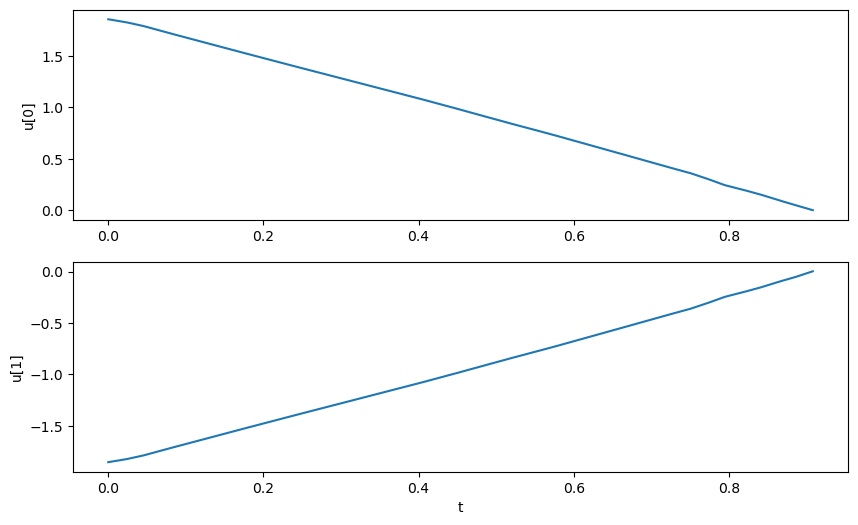

In [41]:
ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
s = x_traj.vector_values(ts)
us = u_traj.vector_values(ts)

# fig, ax = plt.subplots(3, 1, figsize=(10, 8))
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
# ax[0].plot(ts, s[0])
# ax[0].set_ylabel("z")

ax[0].plot(ts, us[0])
ax[0].set_ylabel("u[0]")

ax[1].plot(ts, us[1])
ax[1].set_ylabel("u[1]")
ax[1].set_xlabel("t")
# ax[1].plot(ts, s[1])
# ax[1].set_ylabel("B1_ry")

# ax[2].plot(ts, s[2])
# ax[2].set_ylabel("B1_rx")
# ax[2].set_xlabel("t")

# ax[1].plot(ts, us[2])
# ax[1].set_ylabel("ermidk1")

# ax[1].plot(ts, us[3])
# ax[1].set_ylabel("ermidk1")

# ax[0].plot(s.x, s.z)
# ax[0].set_xlabel("x")
# ax[0].set_ylabel("z")
# ax[0].axis("equal")
# ax[1].plot(ts, u_traj.vector_values(ts).T, label="elevatordot")
# ax[1].plot(ts, s.pitch, label="pitch")
# ax[1].legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf831d60-e146-4439-9c7b-f762dc47b76b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>